In [1]:
import pyVHR as vhr
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Plotting: set 'colab' for Google Colaboratory, 'notebook' otherwise
vhr.plot.VisualizeParams.renderer = 'notebook'  # or 'notebook'

In [2]:
# -- LOAD A DATASET
dataset_name = 'lgi_ppgi'          # the name of the python class handling it 
video_DIR = '../cpi/id2/angelo_talk/'  # dir containing videos
BVP_DIR = '../cpi/id2/angelo_talk/'    # dir containing BVPs GT

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)

dataset.video_EXT = 'mp4'
dataset.__init__(videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

0 ../cpi/id2/angelo_talk/cv_camera_sensor_stream_handler.mp4


In [3]:
# -- PARAMETER SETTING
wsize = 8          # seconds of video processed (with overlapping) for each estimate 
video_idx = 0      # index of the video to be processed
fname = dataset.getSigFilename(video_idx)
sigGT = dataset.readSigfile(fname)
test_bvp = sigGT.data
bpmGT, timesGT = sigGT.getBPM(wsize)
videoFileName = dataset.getVideoFilename(video_idx)
print('Video processed name: ', videoFileName)
fps = vhr.extraction.utils.get_fps(videoFileName)
print('Video frame rate:     ',fps)

Video processed name:  ../cpi/id2/angelo_talk/cv_camera_sensor_stream_handler.mp4
Video frame rate:      25.0


In [4]:
sig_extractor = vhr.extraction.SignalProcessing()
# sig_extractor.display_cuda_device()
# sig_extractor.choose_cuda_device(0)

Use convex hull or face parsing to extract the skin

In [5]:
# CPU based
sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull())
#sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionFaceParsing('CPU'))

# GPU based
# sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull('GPU'))
#sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionFaceParsing('GPU'))

Choose a specific number of frames of the video to process... 

In [6]:
# set the number of seconds (0 for all video)
seconds = 20
sig_extractor.set_total_frames(seconds*fps)

### Color-thresholding

**OPTIONAL**: Both signal extraction and skin extraction have a color-threshold filter for removing unwanted RGB colors. We can set the RGB threshold interval using theese classes:

In [7]:
vhr.extraction.SkinProcessingParams.RGB_LOW_TH = 2
vhr.extraction.SkinProcessingParams.RGB_HIGH_TH = 254

vhr.extraction.SignalProcessingParams.RGB_LOW_TH = 2
vhr.extraction.SignalProcessingParams.RGB_HIGH_TH = 254

In [8]:
# -- SET VISUALIZATION MODE 
sig_extractor.set_visualize_skin_and_landmarks(
      visualize_skin=True, 
      visualize_landmarks=True, 
      visualize_landmarks_number=True, 
      visualize_patch=True)

In [9]:
# -- DEFINE A LANDMARK SUBSET

# choose predefined...
landmarks = vhr.extraction.MagicLandmarks.cheek_left_top +\
                   vhr.extraction.MagicLandmarks.forehead_center +\
                   vhr.extraction.MagicLandmarks.forehoead_right +\
                   vhr.extraction.MagicLandmarks.cheek_right_top +\
                   vhr.extraction.MagicLandmarks.forehead_left +\
                   vhr.extraction.MagicLandmarks.nose 


In [10]:
# -- SET THE LANDMARK LIST
sig_extractor.set_landmarks(landmarks)

## Holistic extraction

In [11]:
# -- HOLISTIC EXTRACTION
hol_sig = sig_extractor.extract_holistic(videoFileName)
print('Size: (#frames, #landmarks, #channels) = ',hol_sig.shape)

Size: (#frames, #landmarks, #channels) =  (500, 1, 3)


In [12]:
# -- INTERACTIVE VISUALIZATION OF PATCHES
visualize_skin_coll = sig_extractor.get_visualize_skin()
print('Number of frames processed: ',len(visualize_skin_coll))
vhr.plot.interactive_image_plot(visualize_skin_coll,1.0)

Number of frames processed:  500


interactive(children=(IntSlider(value=0, description='x', max=499), Output()), _dom_classes=('widget-interact'…

In [13]:
cap = cv2.VideoCapture(video_DIR+"cv_camera_sensor_stream_handler.mp4")
frameRate = cap.get(5)  # frame rate

# Frame dimensions: WxH
frame_dims = (int(cap.get(3)), int(cap.get(4)))
num_frames = int(cap.get(7))

# the following just reads all the frames into a numpy array
# Frames from the video have shape NumFrames x H x W x C
max_frames = seconds * fps
if max_frames < num_frames:
    num_frames = int(max_frames)
frames = np.zeros((num_frames, frame_dims[1], frame_dims[0], 3), dtype='uint8')

frame_counter = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frames[frame_counter, :, :, :] = frame
    frame_counter += 1
    if frame_counter == num_frames:
        break

cap.release()

https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
https://automaticaddison.com/how-to-apply-a-mask-to-an-image-using-opencv/

In [124]:
video = cv2.VideoWriter('mod.mp4',0,25,(frame_dims[0], frame_dims[1]))
for i in range(num_frames):
    image = visualize_skin_coll[i]
    (row, col, ch) = image.shape
    f_mask = np.array(image!=0,dtype=np.bool)
    b_mask = np.array(image==0,dtype=np.bool)
    image[b_mask] = 0
    for ch in range(image.shape[2]):
        mean = 0
        sigma = 10
        gauss = np.random.normal(mean,sigma,(row,col)).astype(np.uint8)
        image[:,:,ch] += gauss # potentielt problem her for hvis værdierne kommer over 255, wrapper de rundt.
    mask = (f_mask.astype(np.int)*255)[:,:,0]
    mask = mask.astype(np.uint8)
    fg = cv2.bitwise_or(image, image, mask=mask)
    fg = cv2.cvtColor(fg, cv2.COLOR_RGB2BGR)

    mask = (b_mask.astype(np.int)*255)[:,:,0]
    mask = mask.astype(np.uint8)
    bg = cv2.bitwise_or(frames[i,:,:,:], frames[i,:,:,:], mask=mask)
    im = fg + bg
    video.write(im)
video.release()

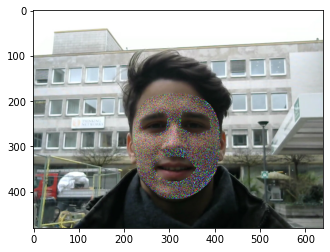

In [128]:
# TODO: skal måske også overveje hvad der skal ved grænseovergangen med ansigtet
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB));

# One pixel

In [14]:
frames.shape

(500, 480, 640, 3)

In [21]:
n_pix = 6
pix = frames[:,210:210+n_pix,310:310+n_pix,0]

In [22]:
pix.shape

(500, 6, 6)

In [23]:
def merge_axis(array, source_axis=0, target_axis=1):
    array = np.moveaxis(array, source_axis, 0)
    array = np.moveaxis(array, target_axis, 1)
    array = np.concatenate(array)
    array = np.moveaxis(array, 0, target_axis-1)
    return array

In [29]:
b = merge_axis(pix,1,2)
# b = merge_axis(a,1,2)

In [30]:
b.shape

(500, 36)

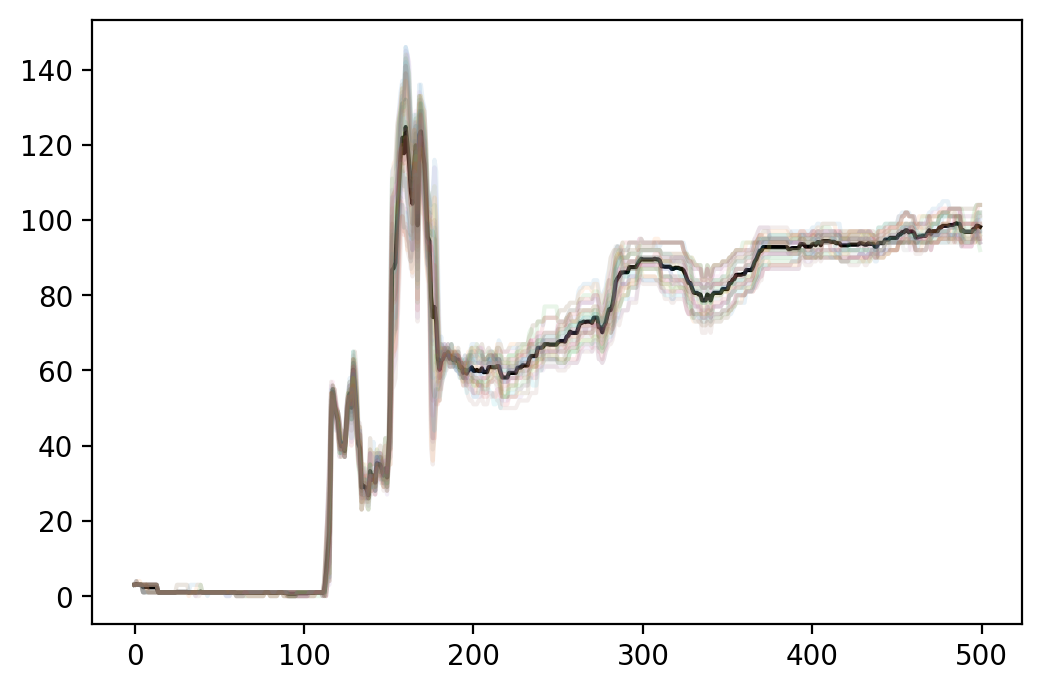

In [38]:
fig, ax = plt.subplots(dpi=200)
ax.plot(np.mean(b,axis=1),'k');
ax.plot(b, alpha=0.1);
# ax.legend(list(range(b.shape[1])));

In [39]:
frames.shape

(500, 480, 640, 3)

In [157]:
import pyVHR as vhr
from pyVHR.BVP import jadeR, RGB_sig_to_BVP
from tqdm.notebook import tqdm

In [158]:
def cpu_ICA2(signal, **kargs):
    """
    ICA method on CPU using Numpy.

    The dictionary parameters are {'component':str}. Where 'component' can be 'second_comp' or 'all_comp'.

    Poh, M. Z., McDuff, D. J., & Picard, R. W. (2010). Non-contact, automated cardiac pulse measurements using video imaging and blind source separation. Optics express, 18(10), 10762-10774.    
    """
    bvp = []
    for X in signal:
        W = jadeR(X, verbose=False)   #W is a 3x3 matrix
        bvp.append(np.dot(W,X))
    
    # selector
    bvp = np.array(bvp)
    l, c, f = bvp.shape     # l=#landmks c=#3chs, f=#frames
    if kargs['component']=='all_comp':
        bvp = np.reshape(bvp, (l*c, f))  # compact into 2D matrix 
    elif kargs['component']=='second_comp':
        bvp = np.reshape(bvp[:,1,:], (l, f))
    
    # collect
    return bvp

In [160]:
w = frames.shape[2]
h = frames.shape[1]

w = range(310, 330)
h = range(210, 230)

hol_bvps = np.zeros((20,20,3,500))

for i in tqdm(w):
    for j in h:
        windowed_hol_sig = frames[:,j,i,:]
        windowed_hol_sig = windowed_hol_sig / 255
        a = np.swapaxes(windowed_hol_sig,0,1)
        b = np.expand_dims(a, 0)
        hol_bvps[i-310, j-210, :, :] = RGB_sig_to_BVP([b], fps, device_type='cpu', method=cpu_ICA2, params={'component':'all_comp'})[0]
        

  0%|          | 0/20 [00:00<?, ?it/s]

In [78]:
hol_bvps.shape

(20, 20, 3, 500)

In [79]:
frames.shape

(500, 480, 640, 3)

In [85]:
a = np.swapaxes(frames,0,2)
frames_r = np.swapaxes(a,-1,-2)

In [134]:
# width, height, ch, (slope, intercept)
linear_models = np.zeros((20,20,3,2))
for i in tqdm(w):
    for j in h:
        for ch in range(hol_bvps.shape[2]):
            linear_model = np.polyfit(frames_r[i, j, ch, :], 
                                    hol_bvps[i-310, j-210, ch, :], 1) # fit 1D polynomium
            # linear_model_fn = np.poly1d(linear_model)
            linear_models[i-310,j-210,ch,0] = linear_model[0]
            linear_models[i-310,j-210,ch,1] = linear_model[1]

  0%|          | 0/20 [00:00<?, ?it/s]

In [131]:
linear_models.shape

(20, 20, 3, 2)

In [133]:
linear_models[0][0][0][:]

array([-0.02424708, -0.6874547 ])

In [146]:
frames_r.shape

(640, 480, 3, 500)

In [163]:
linear_model_fn = np.poly1d(linear_models[0][0][0][:])
linear_model_fn(frames_r[0][0][0][:])

array([-6.87045884, -6.87045884, -6.87045884, -6.87045884, -6.87045884,
       -6.87045884, -6.87045884, -6.87045884, -6.87045884, -6.87045884,
       -6.87045884, -6.87045884, -6.87045884, -6.87045884, -6.87045884,
       -6.87045884, -6.87045884, -6.87045884, -6.87045884, -6.87045884,
       -6.87045884, -6.87045884, -6.87045884, -6.87045884, -6.87045884,
       -6.87045884, -6.87045884, -6.87045884, -6.87045884, -6.87045884,
       -6.87045884, -6.87045884, -6.87045884, -6.87045884, -6.87045884,
       -6.87045884, -6.87045884, -6.87045884, -6.87045884, -6.87045884,
       -6.87045884, -6.87045884, -6.87045884, -6.87045884, -6.87045884,
       -6.87045884, -6.87045884, -6.87045884, -6.84621177, -6.84621177,
       -6.84621177, -6.84621177, -6.84621177, -6.84621177, -6.84621177,
       -6.84621177, -6.84621177, -6.84621177, -6.84621177, -6.84621177,
       -6.84621177, -6.84621177, -6.84621177, -6.84621177, -6.84621177,
       -6.84621177, -6.84621177, -6.84621177, -6.84621177, -6.84

In [ ]:
reconstructed = np.zeros()
for i in tqdm(w):
    for j in h:
        for ch in range(hol_bvps.shape[2]):